# Results

This notebook is created to analyse results from simulations using specifically the ensemble learning approach.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_duplication --aug-strategy-test augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10 --ml-model CONV1D --eval-strategy True
```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import PandasTools

In [2]:
TASK = "ESOL"
STRING_ENCODING = "smiles"
TRAIN_AUGMENTATION = 100
TEST_AUGMENTATION = 100
#AUGMENTATION_STRATEGY = "augmentation_without_duplication"
AUGMENTATION_STRATEGY = "augmentation_with_duplication"
ML_MODEL = "CONV1D"

In [3]:
#TASK = "ESOL"
#STRING_ENCODING = "smiles"
#TRAIN_AUGMENTATION = 0
#TEST_AUGMENTATION = 0
#AUGMENTATION_STRATEGY = "no_augmentation"
#ML_MODEL = "CONV1D"

# Load results

## General results
Here we load the data which contains relevant information, such as
- total time of execution of the script: loading data, featurizing, train, and testing
- training time
- testing time
- the evolution of the loss by epoch
- MSE, RMSE, R2 on train set
- MSE, RMSE, R2 on train set

In [4]:
def load_results(task, string_encoding, augmentation_strategy, train_augmentation, test_augmentation, ml_model):
    with open(f"output/{task}_{string_encoding}_{augmentation_strategy}_{train_augmentation}_{test_augmentation}_{ml_model}/results_metrics.pkl", 'rb') as f: 
        results = pickle.load(f)
        print(f"Data: \t\t\t {task}")
        print(f"String encoding: \t {string_encoding}")
        print(f"Augmentation strategy: \t {augmentation_strategy}")
        print(f"Train augmentation: \t {train_augmentation}")
        print(f"Test augmentation: \t {test_augmentation}")
        print(f"Model: \t\t\t {ml_model}")
        print("\n")
        print(f"Train R2: \t\t {results.train[0][2]:.3f}")
        print(f"Test R2: \t\t {results.test[0][2]:.3f}")
        print(f"Total execution time: \t {results.execution[0]}")
        print(f"Training time: \t\t {results.time_training[0]}")
        return results

In [5]:
results = load_results(TASK, STRING_ENCODING, AUGMENTATION_STRATEGY, TRAIN_AUGMENTATION, TEST_AUGMENTATION, ML_MODEL)

Data: 			 ESOL
String encoding: 	 smiles
Augmentation strategy: 	 augmentation_with_duplication
Train augmentation: 	 100
Test augmentation: 	 100
Model: 			 CONV1D


Train R2: 		 0.987
Test R2: 		 0.925
Total execution time: 	 0 days 00:28:11.432880
Training time: 		 0 days 00:25:30.804204


In [6]:
results

,execution,time_training,time_testing,loss,train,test
0,0 days 00:28:11.432880,0 days 00:25:30.804204,0 days 00:00:16.517917,"[0.040372018813343506, 0.01875718626544755, 0....","(0.05643834173679352, 0.23756755888462067, 0.9...","(0.32957857847213745, 0.5740893483161926, 0.92..."


## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- confidence of the prediction (is the standard deviation low or high?)
- the absolute error between the true value and the average value

This data represents _only_ the test set (20%) and not the full data (100%). It contains most relevant information.

In [7]:
with open(f"output/{TASK}_{STRING_ENCODING}_{AUGMENTATION_STRATEGY}_{TRAIN_AUGMENTATION}_{TEST_AUGMENTATION}_{ML_MODEL}/results_ensemble_learning.pkl", 'rb') as f: 
    test_data = pickle.load(f)

In [8]:
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
181,-8.60,CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1,"[C(C)Oc1ccc(C(C)(C)COCc2cccc(c2)Oc2ccccc2)cc1,...","[C(C)Oc1ccc(C(C)(C)COCc2cccc(c2)Oc2ccccc2)cc1,...",-6.481063,0.444268
277,-0.60,CCS,"[C(S)C, C(S)C, C(S)C, C(S)C, C(S)C, C(S)C, C(S...","[C(S)C, C(S)C, C(S)C, C(S)C, C(S)C, C(S)C, C(S...",-0.979006,0.117905
125,-0.60,CC(=O)OCC(COC(C)=O)OC(C)=O,"[CC(=O)OCC(OC(=O)C)COC(=O)C, O=C(OCC(COC(=O)C)...","[CC(=O)OCC(OC(=O)C)COC(=O)C, O=C(OCC(COC(=O)C)...",-1.144300,0.399497
937,-0.67,CCC(C)C(C)=O,"[C(C(C)CC)(=O)C, C(C(C)CC)(=O)C, CC(C(=O)C)CC,...","[C(C(C)CC)(=O)C, C(C(C)CC)(=O)C, CC(C(=O)C)CC,...",-1.006674,0.204917
444,-5.05,C=CCCCCCCC,"[C(CC)CCCCC=C, C(CC)CCCCC=C, C(CC)CCCCC=C, C(C...","[C(CC)CCCCC=C, C(CC)CCCCC=C, C(CC)CCCCC=C, C(C...",-5.182458,0.147329


# Some statistics

### Distribution of the target

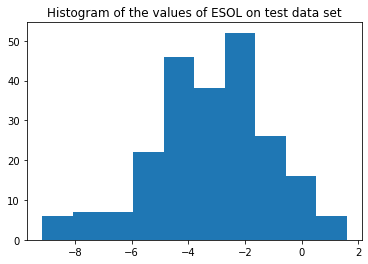

Minimum value: -9.15
Minimum value: 1.58


In [9]:
fig, ax = plt.subplots()
plt.hist(test_data['target'])
ax.set_title(f"Histogram of the values of {TASK} on test data set")
plt.show()
print(f"Minimum value: {test_data['target'].min()}")
print(f"Minimum value: {test_data['target'].max()}")

### Range of standard deviation of prediction

In [10]:
print(f"Minimum: {test_data['std_prediction'].min():.2f} \t \t associated index: {test_data['std_prediction'].idxmin()}")

Minimum: 0.00 	 	 associated index: 835


In [11]:
print(f"Maximum: {test_data['std_prediction'].max():.2f} \t \t associated index: {test_data['std_prediction'].idxmax()}")

Maximum: 0.56 	 	 associated index: 272


### Look at the molecules

In [12]:
def ensemble_learning_metric(metric="min", num=3, augmentation_strategy=AUGMENTATION_STRATEGY):
    """
    Return the rdkit molecule object with `metric` standard deviation.
    
    Parameters
    ----------
    metric : str
        The metric to consider for the standard deviation of the prediction.
    num : int
        The number `num` to consider.
    
    Returns
    -------
    tuple
        target, canonical SMILES, random SMILES, RDKit molecule.
    """
    
    print("Augmentation strategy: ", AUGMENTATION_STRATEGY)
    print("\n")
    if metric == "min":
        selection = test_data.nsmallest(num, 'std_prediction', keep="all")
    if metric == "max":
        selection = test_data.nlargest(num, 'std_prediction', keep="all")
        
    for index in selection.index:
        canonical_smile = test_data.loc[index]["canonical_smiles"]
        mol = Chem.MolFromSmiles(canonical_smile)
        print("Canonical SMILES: ",  canonical_smile)
        random_smiles = test_data.loc[index]["augmented_smiles"]
        target = test_data.loc[index]["target"]
        print(f"True value: {target:.2f}")
        average_prediction = test_data.loc[index]['average_prediction']
        print(f"Average prediction: {average_prediction:.2f}")
        absolute_error = np.absolute(test_data.loc[index]["target"]-test_data.loc[index]["average_prediction"])
        print(f"Absolute of the averaged error: {absolute_error:.2f}")
        selection.loc[index, "absolute_average_error"] = absolute_error
        #print(mol)
        print("\n")
        PandasTools.AddMoleculeColumnToFrame(selection, smilesCol='canonical_smiles')
    return selection

Augmentation strategy:  augmentation_with_duplication


Canonical SMILES:  c1ccccc1
True value: -1.64
Average prediction: -1.97
Absolute of the averaged error: 0.33


Canonical SMILES:  BrCCBr
True value: -1.68
Average prediction: -1.55
Absolute of the averaged error: 0.13


Canonical SMILES:  BrCBr
True value: -1.17
Average prediction: -1.06
Absolute of the averaged error: 0.11




,target,average_prediction,absolute_average_error,std_prediction,canonical_smiles,ROMol
835,-1.64,-1.973259,0.333259,0.000000,c1ccccc1,
1012,-1.68,-1.547675,0.132325,0.019760,BrCCBr,
614,-1.17,-1.061414,0.108586,0.028614,BrCBr,

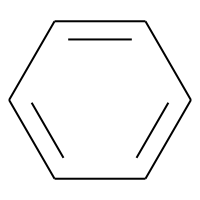
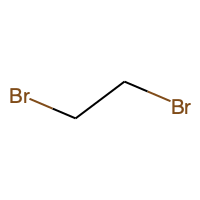
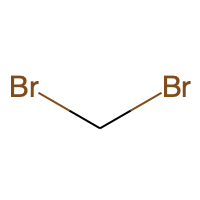

In [13]:
high_confidence_mol = ensemble_learning_metric("min")
high_confidence_mol[["target", "average_prediction", "absolute_average_error", "std_prediction", "canonical_smiles", "ROMol"]]

Augmentation strategy:  augmentation_with_duplication


Canonical SMILES:  CC1(C)C(C=C(Br)Br)C1C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1
True value: -8.40
Average prediction: -7.45
Absolute of the averaged error: 0.95


Canonical SMILES:  O=C1NC(=O)C2C3C(C(O)(c4ccccc4)c4ccccn4)=CC(C3=C(c3ccccc3)c3ccccn3)C12
True value: -3.93
Average prediction: -5.62
Absolute of the averaged error: 1.69


Canonical SMILES:  CCCCC(=O)OC1(C(=O)CO)C(C)CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC21C
True value: -4.71
Average prediction: -5.57
Absolute of the averaged error: 0.86




,target,average_prediction,absolute_average_error,std_prediction,canonical_smiles,ROMol
272,-8.402,-7.447228,0.954772,0.565000,CC1(C)C(C=C(Br)Br)C1C(=O)OC(C#N)c1cccc(Oc2cccc...,
922,-3.931,-5.619806,1.688806,0.491904,O=C1NC(=O)C2C3C(C(O)(c4ccccc4)c4ccccn4)=CC(C3=...,
851,-4.710,-5.570812,0.860812,0.487199,CCCCC(=O)OC1(C(=O)CO)C(C)CC2C3CCC4=CC(=O)C=CC4...,

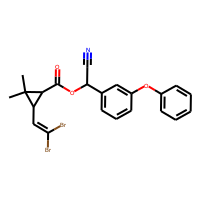
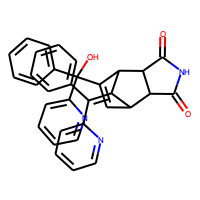
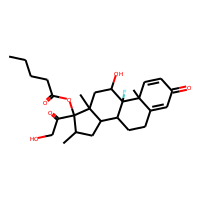

In [14]:
low_confidence_mol = ensemble_learning_metric("max")
low_confidence_mol[["target", "average_prediction", "absolute_average_error", "std_prediction", "canonical_smiles", "ROMol"]]

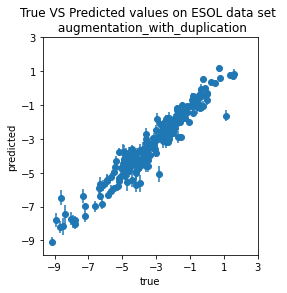

In [15]:
fig, ax = plt.subplots()
x = test_data["target"]
y = test_data["average_prediction"]
err = test_data["std_prediction"]

plt.errorbar(x, y, yerr=err, fmt='o')

ax.set_xticks(np.arange(-9, 4, 2))
ax.set_yticks(np.arange(-9, 4, 2))
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_aspect("equal", adjustable="box")
ax.set_title(f"True VS Predicted values on {TASK} data set \n {AUGMENTATION_STRATEGY}")

plt.show()